# Laboratorium 6

1.2.6 Zjawisko przeuczenia + regularyzacja

Zaimplementować mechanizm regularyzacji wag w sieci oraz mechanizm zatrzymywania uczenia przy wzroście błędu na zbiorze walidacyjnym.

Przeprowadzić eksperymenty na zbiorach i porównać skuteczność na zbiorze testowym dla różnych wariantów przeciwdziałania przeuczeniu sieci:

    multimodal-sparse,
    rings5-sparse,
    rings3-balance,
    xor3-balance.



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import math

## Klasa mlp

In [44]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_der - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej
    softmax_metod - zastosowanie softmax na ostatniej warstwie
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, softmax_method = False, regularization = "none"):
        self.layers = layers
        self.softmax_method = softmax_method
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []
        
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_der = self.sigmoid_der
        elif activation_function == "linear":
            self.activation_function = self.linear
            self.activation_function_der = self.linear_der
        elif activation_function == "tanh":
            self.activation_function = self.tanh
            self.activation_function_der = self.tanh_der
        elif activation_function == "relu":
            self.activation_function = self.relu
            self.activation_function_der = self.relu_der

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci 
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        results = a @ self.weights[-1] + self.biases[-1]
        if self.softmax_method:
            results = self.softmax(results)
        self.z.append(results)
        self.A.append(results)
        return results

    def backward(self, y):
        """
        propagacja wsteczna
        """
        m = y.shape[0]
        D = [None] * len(self.weights)
        
        if self.softmax_method:
            temp = []
            for a, y_ in zip(self.A[-1], y):
                error = y_ - a
                a_ = a.reshape(a.shape[0], )
                si_sj = - a_ * a_.reshape(self.layers[-1], 1)
                sof_der = np.diag(a_) + si_sj
                temp.append(sof_der @ error)

            temp = np.array(temp)
            D[-1] = temp
        
        else:
            D[-1] = y - self.A[-1]
        
        
        for i in reversed(range(len(D) - 1)):
            D[i] = ((self.weights[i + 1] @ D[i + 1].T ) * self.activation_function_der(self.z[i]).T).T

        delta_b = [None] * len(D)
        delta_w = [None] * len(D)
        
        for i, d in enumerate(D):
            delta_w[i] = (d.T @ self.A[i]).T / m
            delta_b[i] = (d.T @ np.ones((m, 1))).T / m

        return delta_w, delta_b

    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, 
              method = "Classic", var=0.4, lambda_=0, inc_stop = False):
        """
        alpha - learning rate
        method - wybór metody uczenia Classic(default)/Momentum/RMSProp
        var - współczynnik wygaszania
        """
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        tr = math.floor(0.9*len(x))
        x_test = x[tr:]
        y_test = y[tr:]
        x = x[:tr]
        y = y[:tr]
        
        m = x.size
        
        min_error = math.inf
        current_error = 0
        
        method_w = [np.zeros(w.shape) for w in self.weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                delta_w, delta_b = self.backward(y_batch)
                
                if method == "Classic":
                    for j, weight in enumerate(self.weights):    
                        self.weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]   
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
            current_error = 1/m * mean_squared_error(self.forward(x_test), y_test) + lambda_ * sum([np.sum(np.abs(x)) + np.sum(np.abs(y)) for x,y in zip(self.weights,self.biases)]) / (2*m)
            if (inc_stop * current_error > 1.5 * min_error):
                break
            if (current_error < min_error):
                min_error = current_error
                
    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]
    
    
    @staticmethod
    def sigmoid(x):
        z = np.array(x)
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_der(x):
        return MLP.sigmoid(x) * (1 - MLP.sigmoid(x))
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
    @staticmethod
    def linear(x):
        return np.array(x)
    
    @staticmethod
    def linear_der(x):
        return np.ones(x.shape)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_der(x):
        return 1/np.cosh(x)**2
    
    @staticmethod
    def relu(x):
        z = np.array(x)    
        return np.maximum(0,z)
    
    @staticmethod
    def relu_der(x):
        z = np.array(x)    
        z[z<0]=0
        z[z!=0] = 1
        return z


### Multimodal sparse

In [45]:
train_df = pd.read_csv('mio_data/regression/multimodal-sparse-training.csv')
test_df = pd.read_csv('mio_data/regression/multimodal-sparse-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)

x_normalized = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
y_normalized = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

x_normalized_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)
y_normalized_test = np.asarray((test_df['y']-test_df['y'].mean())/test_df['y'].std()).reshape(-1, 1)


In [46]:
iterations_set = [1,5,10,25,50]

In [63]:
layers = [1, 10, 1]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_def.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                          alpha=0.01, lambda_=0, inc_stop = True)
        results_def_temp.append(mean_absolute_error(y_normalized_test, 
                                                        mlp_def.forward(x_normalized_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = False)

        mlp_reg.learn(x_normalized, y_normalized, iterations=iterations, batch_size = 20, 
                       alpha=0.01, lambda_=1, inc_stop = True)
        results_reg_temp.append(mean_absolute_error(y_normalized_test, 
                                                     mlp_reg.forward(x_normalized_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

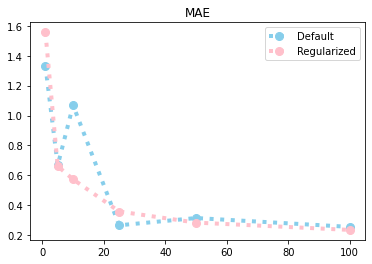

In [64]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("MAE")
plt.legend()

Widzimy, że obie sieci osiągnęły bardzo podobne rezultaty, jednak sieć z regularyzacją zbiegła szybciej.

## Rings5 

In [65]:
train_df = pd.read_csv('mio_data/classification/rings5-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings5-regular-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [66]:
iterations_set = [1,5,10,25,50,100]

In [67]:
layers = [2, 16,16, 5]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

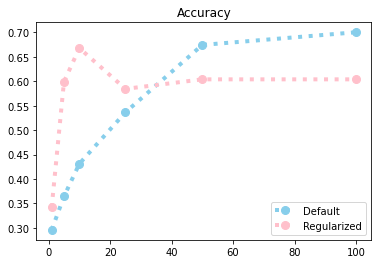

In [68]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

W tym przypadku sieć regularyzowana poradziła sobie gorzej od domyślnej. Może to wynikać ze struktury zbioru.

## Rings3

In [54]:
train_df = pd.read_csv('mio_data/classification/rings3-balance-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-balance-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [55]:
iterations_set = [1,5,10,25,50,100]

In [56]:
layers = [2, 16,16, 3]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

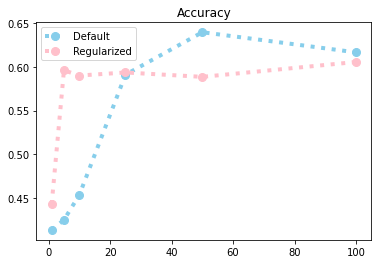

In [57]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

W tym przypadku lepiej wypadła sieć domyślna, jednak warto zwrócić uwagę, że sieć regularyzowana zbiegła bardzo szybko w porównaniu do domyślnej. 

## XOR3

In [69]:
train_df = pd.read_csv('mio_data/classification/xor3-balance-training.csv')
test_df = pd.read_csv('mio_data/classification/xor3-balance-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()
normalized_test_df=(test_df-test_df.mean())/test_df.std()


x = np.asarray(normalized_train_df[['x', 'y']])
x_test = np.asarray(normalized_test_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
c_test = np.asarray(test_df['c']).reshape(-1, 1)

encoded = to_categorical(c)

In [70]:
iterations_set = [1,5,10,25,50,100]

In [71]:
layers = [2, 16,16, 2]

results_def = []
results_reg = []

for iterations in iterations_set:
    for _ in range (2):
        results_def_temp = []
        results_reg_temp = []
        
        mlp_def = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_def.learn(x, encoded, iterations=iterations, batch_size = 20, 
                          alpha=0.01, var=0.9, method = "Momentum", lambda_=0, inc_stop = True)
        results_def_temp.append(accuracy_score(c_test, mlp_def.classify(x_test)))

        mlp_reg = MLP(
        layers = layers, 
        weights_biases = "Xavier",
        activation_function = "tanh", 
        softmax_method = True)

        mlp_reg.learn(x, encoded, iterations=iterations, batch_size = 20, 
                       alpha=0.1, var=0.9, method = "Momentum", lambda_=1, inc_stop = True)
        results_reg_temp.append(accuracy_score(c_test, mlp_reg.classify(x_test)))

    results_def.append(np.mean(results_def_temp))
    results_reg.append(np.mean(results_reg_temp))

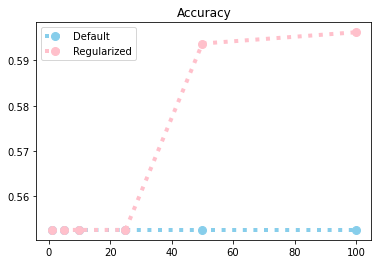

In [72]:
df=pd.DataFrame({'x_values': iterations_set, 'Default': results_def,
                                             'Regularized': results_reg})
plt.plot( 'x_values', 'Default', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Regularized', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.title("Accuracy")
plt.legend()

Bardzo ciekawy eksperyment, widzimy, że zwykład sieć wyraźnie nie radzi sobie z tym zbiorem, natomiast sieć z regularyzacją wychodzi obronną ręką.